In [17]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [18]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()
backend

AerSimulator('aer_simulator')

In [19]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("IZ", -0.3980), ("ZI", -0.0113), ("XX", 0.1810)]
# )
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 1), ("ZI", 1), ("ZZ", 1), ("XX", 1)]
# )
# hamiltonian = SparsePauliOp.from_list(
#         [
#         ('IIII', -0.09706627+0.j), ('ZIII',  0.17141283+0.j), ('IZII',  0.17141283+0.j),
#         ('IIZI', -0.22343154+0.j), ('IIIZ', -0.22343154+0.j), ('ZZII',  0.16868898+0.j),
#         ('ZIZI',  0.12062523+0.j), ('ZIIZ',  0.16592785+0.j), ('IZZI',  0.16592785+0.j),
#         ('IZIZ',  0.12062523+0.j), ('IIZZ',  0.17441288+0.j),
#         ('XXYY', -0.04530262+0.j),
#         ('XYYX',  0.04530262+0.j),
#         ('YXXY',  0.04530262+0.j),
#         ('YYXX', -0.04530262+0.j)
#     ]
# )
hamiltonian = SparsePauliOp.from_list(
    [('XXYY', -0.04530262+0.j)])


$H = Y_0Y_1X_2X_3$

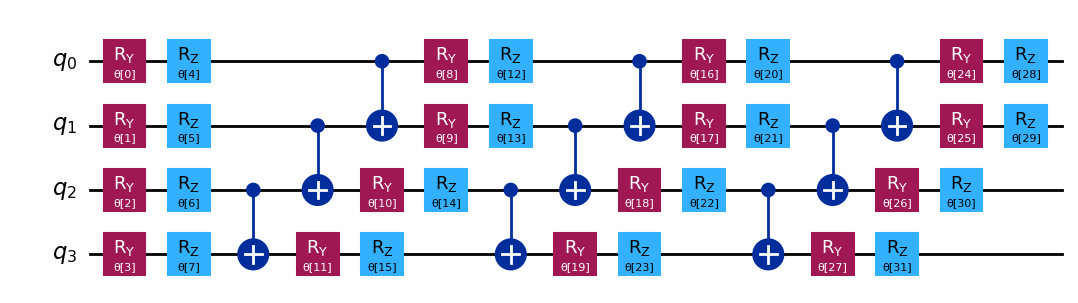

In [36]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp", reverse_bits=False)

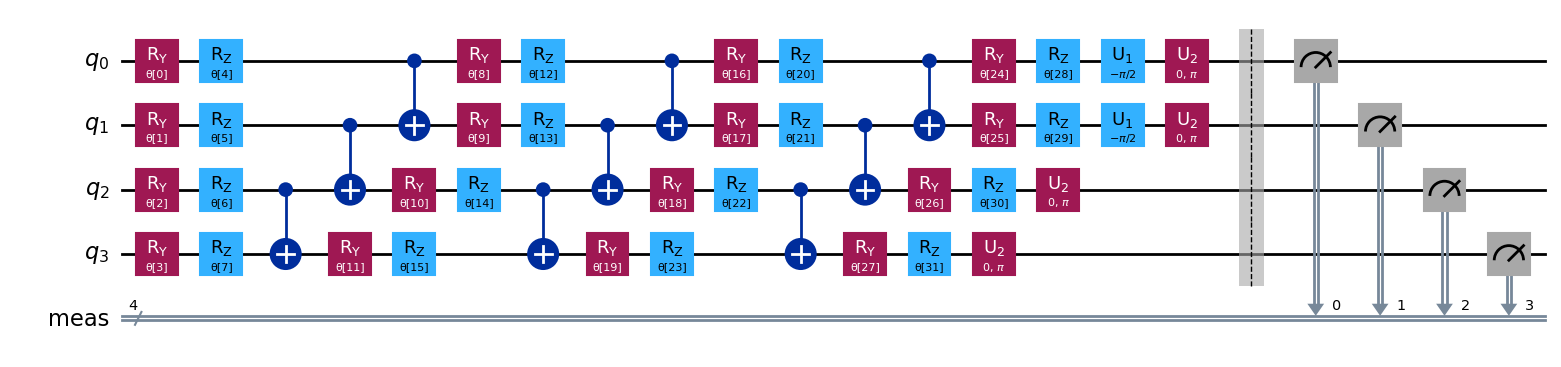

In [40]:
# ansatz = EfficientSU2(hamiltonian.num_qubits)
# ansatz.sdg([0,1])
# ansatz.h([0,1,2,3])
# ansatz.measure_all()
# ansatz.decompose().draw(style='iqp', reverse_bits=False)

In [21]:
num_params = ansatz.num_parameters
num_params

32

In [22]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

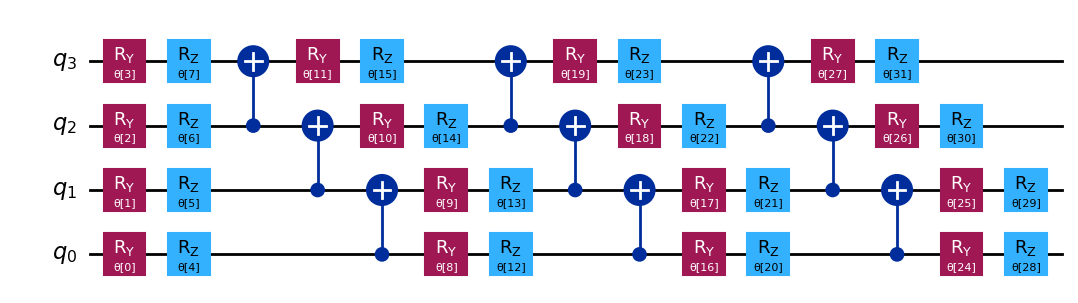

In [23]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [24]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

#### Cost Function

In [25]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    print(result[0].data.evs)
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [26]:
np.random.seed(42)
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122,
       0.12933619, 6.09412333, 5.23039137, 1.33416598, 1.14243996,
       1.15236452, 1.91161039, 3.2971419 , 2.71399059, 1.82984665,
       3.84438512, 0.87646578, 1.83559896, 2.30191935, 2.86557222,
       4.93340606, 1.25458737, 3.23103027, 3.72225051, 0.29185655,
       3.81731689, 1.07143467])

In [27]:
estimator = Estimator(backend=AerSimulator())
estimator.options.seed_estimator = 10
print(estimator.options.seed_estimator)

10


In [28]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000
    estimator.options.seed_estimator = 10

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

[-0.02541636]
Iters. done: 1 [Current cost: -0.025416362490234375]
[-0.02371309]
Iters. done: 2 [Current cost: -0.02371309015625]
[-0.01904568]
Iters. done: 3 [Current cost: -0.019045681552734377]
[-0.02495183]
Iters. done: 4 [Current cost: -0.024951833671875]
[-0.0202623]
Iters. done: 5 [Current cost: -0.0202623046484375]
[-0.01838207]
Iters. done: 6 [Current cost: -0.018382068955078126]
[-0.02552696]
Iters. done: 7 [Current cost: -0.02552696458984375]
[-0.01517461]
Iters. done: 8 [Current cost: -0.015174608066406251]
[-0.01479856]
Iters. done: 9 [Current cost: -0.014798560927734376]
[-0.00559647]
Iters. done: 10 [Current cost: -0.005596466240234375]
[-0.0261021]
Iters. done: 11 [Current cost: -0.026102095507812503]
[-0.0218771]
Iters. done: 12 [Current cost: -0.021877095302734375]
[-0.00975511]
Iters. done: 13 [Current cost: -0.009755105185546875]
[-0.02692055]
Iters. done: 14 [Current cost: -0.026920551044921876]
[-0.01621427]
Iters. done: 15 [Current cost: -0.016214267802734376]
[-

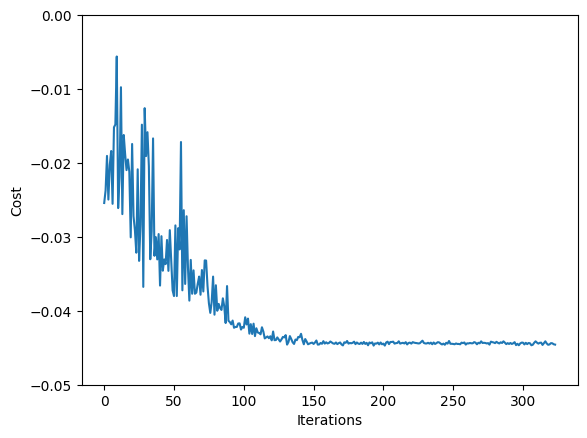

In [32]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.set_ylim(-0.05,0)
plt.draw()


In [30]:
# with Session(backend=backend) as session:
#     estimator = Estimator(session=session)
#     estimator.options.default_shots = 1000
#     estimator.options.seed_estimator = 10

#     res = minimize(
#         cost_func,
#         x0,
#         args=(ansatz_isa, hamiltonian_isa, estimator),
#         method="cobyla",
#     )

In [31]:
# fig, ax = plt.subplots()
# ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Cost")
# plt.draw()